# Discrete Convolution and Correlation

This notebook illustrates the (discrete) linear and circular convolutions.

* Graham, L., D. E. Knuth, and O. Patashnik (1994). Concrete mathematics: a foundation for computer science, 2 ed.: Addison-Wesley Publishing Company. ISBN 0-201-55802-5

* Yilmaz, Öz (2001). Seismic Data Analysis: Processing, Inversion, and Interpretation of Seismic Data, 2 ed.: Society of Exploration Geophysicists. ISBN 1-56080-098-4

* Oppenheim, A. V., and Schafer, R., W. (2010). Discrete-Time Signal Processing, 3 ed.: Pearson. ISBN 0-13-198842-5

* Uieda, L., V. C. Oliveira Jr, and V. C. F. Barbosa (2013), Modeling the Earth with Fatiando a Terra, Proceedings of the 12th Python in Science Conference, pp. 91 - 98. url: https://www.fatiando.org/v0.5/cite.html#cite

<a id='ref'></a>
## References

* Yilmaz, Öz (2001). Seismic Data Analysis: Processing, Inversion, and Interpretation of Seismic Data, 2 ed.: Society of Exploration Geophysicists. ISBN 1-56080-098-4

In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.signal import savgol_filter
from scipy.linalg import toeplitz, circulant, dft
import matplotlib.pyplot as plt
import my_functions as mfun

<a id='sec1'></a>
## Synthetic data

In [2]:
# number of samples
N = 800

# period (in seconds)
T0 = 1

# sampling interval (is seconds)
dt = T0/N
print(dt)

# time (in seconds)
t = np.linspace(0, N*dt, N)

0.00125


In [3]:
def synthetic_signal(A, f, t):
    signal = np.zeros_like(t)
    for Ai, fi in zip(A, f):
        signal += Ai*np.sin(2*np.pi*fi*t)
    return signal

In [4]:
f = [10, 30,  2] # Hertz (Hz)
A = [10,  5, 15] # Amplitude

signal = synthetic_signal(A, f, t)

signal1 = synthetic_signal([A[0]], [f[0]], t)
signal2 = synthetic_signal([A[1]], [f[1]], t)
signal3 = synthetic_signal([A[2]], [f[2]], t)

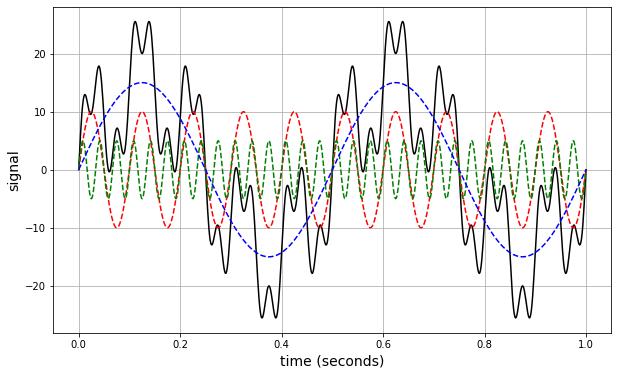

In [5]:
plt.figure(figsize=(10,6))
plt.plot(t, signal, 'k-')
plt.plot(t, signal1, 'r--')
plt.plot(t, signal2, 'g--')
plt.plot(t, signal3, 'b--')
plt.xlabel('time (seconds)', fontsize=14)
plt.ylabel('signal', fontsize=14)
plt.grid()
plt.show()

## Filtering in frequency domain by using a box filter

According to equation 10 of the notebook `convolution_correlation_1D_1`, the circular convolution in frequency domain is given by:

$$
\frac{1}{\sqrt{N}} \mathbf{F}_{(N)} \mathbf{w} = \left( \mathbf{F}_{(N)} \, \mathbf{b} \right) \circ 
\left( \mathbf{F}_{(N)} \, \mathbf{a} \right) \: ,
$$

where $\mathbf{F}_{(N)}$ is the $N \times N$ Fourier matrix with scale factor $\sqrt{N}$. Lets consider that $\mathbf{a}$ represents our signal, in time domain. In this case, the term $\mathbf{F}_{(N)} \, \mathbf{b}$ represents our filter, in frequency domain and the left-hand side of this equation represents the filtered signal in the Fourier domain.

In [6]:
FT_signal = fft(x=signal, norm='ortho')

In [7]:
Amplitude_signal = np.abs(FT_signal)
Amp_max_signal = np.max(Amplitude_signal)

In [8]:
# create the vector of frequencies
freqs = fftfreq(n=N, d=dt)

In [9]:
def filter_box(freqs, cutoff):
    assert cutoff, 'cuttof is positive'
    f = np.ones_like(freqs)
    N = freqs.size
    mask_lower = (np.abs(freqs) < cutoff)
    mask_equal = (np.abs(freqs) == cutoff)
    mask_greater = (np.abs(freqs) > cutoff)
    # f[mask_lower] = np.sqrt(N)
    # f[mask_equal] = 0.5*np.sqrt(N)
    f[mask_lower] = 1
    f[mask_equal] = 0.5
    f[mask_greater] = 0
    return f

In [10]:
# define the cutoff frequency
freq_cut = 15

In [11]:
np.min(freqs), np.max(freqs)

(-400.0, 399.0)

In [12]:
# Define the filter in frequency domain
box = filter_box(freqs=freqs, cutoff=freq_cut)

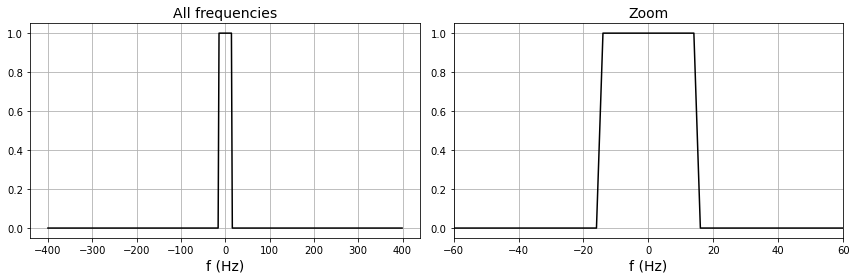

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('All frequencies', fontsize=14)
plt.plot(fftshift(freqs), fftshift(box), 'k-')
plt.xlabel('f (Hz)', fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.title('Zoom', fontsize=14)
plt.plot(fftshift(freqs), fftshift(box), 'k-')
plt.xlabel('f (Hz)', fontsize=14)
plt.xlim(-60, 60)
plt.grid()

plt.tight_layout()

plt.show()

Our filter is an $N \times 1$ vector (where $N$ is the number of samples) formed by ones and zeros. The ones are placed at the positions with absolute frequencies smaller than `freq_cut`.

In [14]:
# Compute the circular convolution in frequency domain
FT_w = np.sqrt(N)*box*FT_signal

In [15]:
Amplitude_w = np.abs(FT_w)
Amp_max_w = np.max(Amplitude_w)

In [16]:
w = ifft(x=FT_w, norm='ortho').real

In [17]:
# Divide the circular convolution by the scale factor to obtain the filtered signal
Amplitude_filtered_freq = Amplitude_w/np.sqrt(N)
signal_filtered_freq = w/np.sqrt(N)

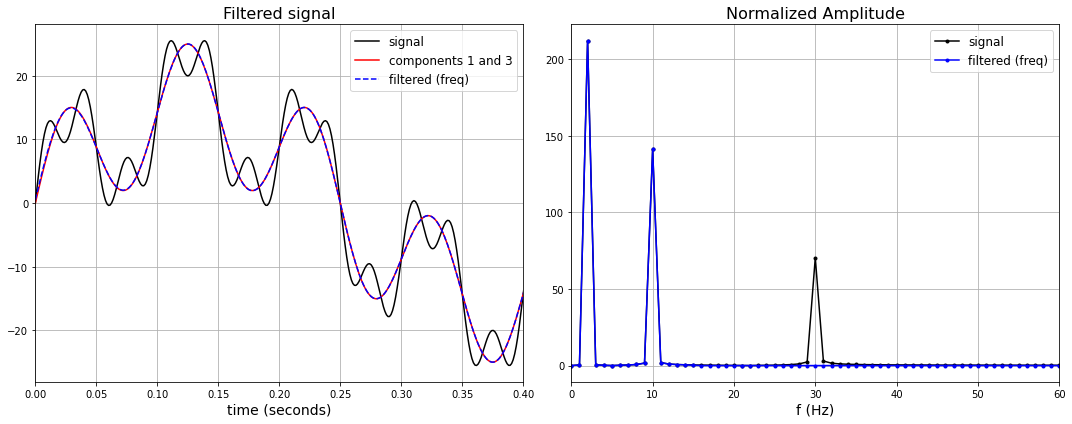

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Filtered signal', fontsize=16)
plt.plot(t, signal, 'k-', label='signal')
plt.plot(t, signal1+signal3, 'r-', label='components 1 and 3')
plt.plot(t, signal_filtered_freq, 'b--', label='filtered (freq)')
plt.xlabel('time (seconds)', fontsize=14)
plt.xlim(0, 0.4)
plt.grid()
plt.legend(loc='best', fontsize=12)

plt.subplot(1,2,2)
plt.title('Normalized Amplitude', fontsize=16)
plt.plot(freqs[:N//2], Amplitude_signal[:N//2], 'k.-', label='signal')
plt.plot(freqs[:N//2], Amplitude_filtered_freq[:N//2], 'b.-', label='filtered (freq)')
plt.xlim(0, 60)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.xlabel('f (Hz)', fontsize=14)

plt.tight_layout()

plt.show()

The operation of "removing parts of our signal" is represented by the Hadamard (entry-wise) product of the Amplitude spectra (continuous black line) and a filter (dashed red line). Notice that this product replaced all values of the Fourier Transform with absolute frequencies greater that `freq_cut`. The result is a filtered signal (dashed blue line) without the component with frequency `f = 30` Hz and amplitude `A = 5`.

## Express the filtering process as a convolution in time domain

According to equation 8 of the notebook `convolution_correlation_1D_1`, the circular convolution in data (time) domain is given by:

$$
\mathbf{w} = \mathbf{C} \, \mathbf{a} \: ,
$$

where $\mathbf{C}$ is an $N \times N$ circulant matrix whose first column is formed by a vector $\mathbf{b}$. Lets consider that $\mathbf{a}$ represents our signal, in time domain. In this case, $\mathbf{b}$ and $\mathbf{w}$ represent, respectively, our box filter and its circular convolution with our signal, both in time domain. As in the frequency domain, our filtered signal in time domain is given by $\mathbf{w} \big{/} \sqrt{N}$.

In [19]:
IFT_box = ifft(x=box, norm='ortho')

In [20]:
C = circulant(IFT_box.real)

In [21]:
w = np.dot(C, signal)

In [22]:
signal_filtered_time = w/np.sqrt(N)

In [23]:
FT_filtered_time = fft(x=signal_filtered_time, norm='ortho')

In [24]:
Amplitude_filtered_time = np.abs(FT_filtered_time)

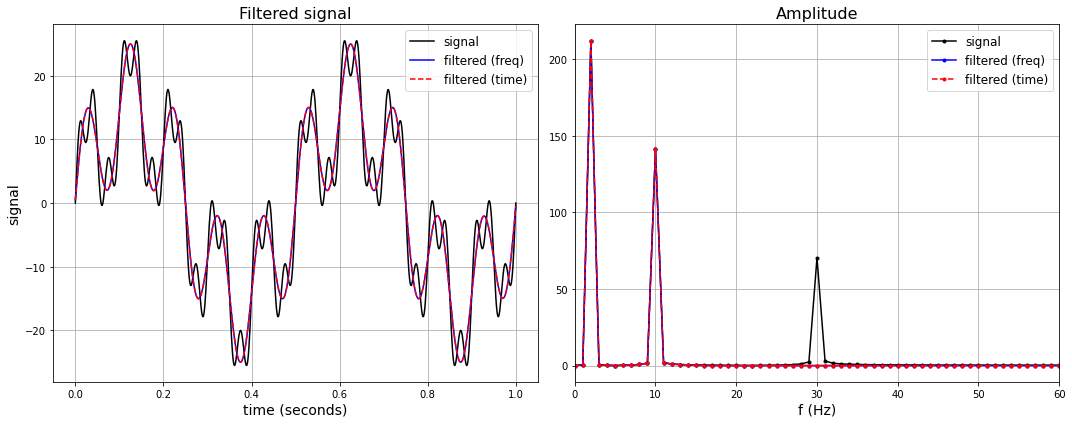

In [25]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Filtered signal', fontsize=16)
plt.plot(t, signal, 'k-', label='signal')
plt.plot(t, signal_filtered_freq, 'b-', label='filtered (freq)')
plt.plot(t, signal_filtered_time, 'r--', label='filtered (time)')
plt.xlabel('time (seconds)', fontsize=14)
plt.ylabel('signal', fontsize=14)
#plt.xlim(0, 0.4)
plt.grid()
plt.legend(loc='best', fontsize=12)

plt.subplot(1,2,2)
plt.title('Amplitude', fontsize=16)
plt.plot(freqs[:N//2], Amplitude_signal[:N//2], 'k.-', label='signal')
plt.plot(freqs[:N//2], Amplitude_filtered_freq[:N//2], 'b.-', label='filtered (freq)')
plt.plot(freqs[:N//2], Amplitude_filtered_time[:N//2], 'r.--', label='filtered (time)')
plt.xlim(0, 60)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.xlabel('f (Hz)', fontsize=14)

plt.tight_layout()

plt.show()

## What if our signal isn't sampled on a complete period?

In [ ]:
N_crop_atfer = 100
N_crop_before = 100
N_cropped = N - N_crop_before - N_crop_atfer

In [ ]:
signal_cropped = signal[N_crop_before:N-N_crop_atfer]
t_cropped = t[N_crop_before:N-N_crop_atfer]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t, signal, 'k-', linewidth=3, label='signal')
plt.plot(t_cropped, signal_cropped, 'r--', label='cropped')
plt.xlabel('time (seconds)', fontsize=14)
plt.ylabel('signal', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [ ]:
FT_signal_cropped = fft(x=signal_cropped, norm='ortho')

In [ ]:
Amplitude_signal_cropped = np.abs(FT_signal_cropped)
Amp_max_signal_cropped = np.max(Amplitude_signal_cropped)

In [ ]:
# create the vector of frequencies
freqs_cropped = fftfreq(n=N_cropped, d=dt)

In [ ]:
# define the cutoff frequency
freq_cut = 15

In [ ]:
# Define the filter in frequency domain
box_cropped = filter_box(freqs=freqs_cropped, cutoff=freq_cut)

In [ ]:
# Compute the circular convolution in frequency domain
FT_w_cropped = np.sqrt(N_cropped)*box_cropped*FT_signal_cropped

In [ ]:
Amplitude_w_cropped = np.abs(FT_w_cropped)
Amp_max_w_cropped = np.max(Amplitude_w_cropped)

In [ ]:
w_cropped = ifft(x=FT_w_cropped, norm='ortho').real

In [ ]:
# Divide the circular convolution by the scale factor to obtain the filtered signal
Amplitude_cropped_filtered_freq = Amplitude_w_cropped/np.sqrt(N_cropped)
signal_cropped_filtered_freq = w_cropped/np.sqrt(N_cropped)

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title('Filtered signal', fontsize=16)
plt.plot(t, signal, 'k-', linewidth=2, label='signal')
#plt.plot(t_cropped, signal_cropped, 'r--', label='cropped')
plt.plot(t, signal_filtered_freq, 'b--', label='filtered (freq)')
plt.plot(t_cropped, signal_cropped_filtered_freq, 'r--', label='filtered (freq) - crop')
plt.xlabel('time (seconds)', fontsize=14)
#plt.xlim(0, 0.4)
plt.grid()
plt.legend(loc='best', fontsize=12)

plt.subplot(1,2,2)
plt.title('Amplitude', fontsize=16)
plt.plot(freqs[:N//2], Amplitude_signal[:N//2], 'k.-', label='signal')
plt.plot(freqs[:N//2], Amplitude_filtered_freq[:N//2], 'b.-', label='filtered (freq)')
plt.plot(freqs_cropped[:N_cropped//2], Amplitude_cropped_filtered_freq[:N_cropped//2], 
         'r.-', label='filtered (freq) - crop')
plt.xlim(0, 60)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.xlabel('f (Hz)', fontsize=14)

plt.tight_layout()

plt.show()